<center>
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/Logos/organization_logo/organization_logo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:


In [209]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Lets download the dataset


In [210]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2020-10-13 01:45:53--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 67.228.254.196
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: 'loan_train.csv'

     0K .......... .......... ..                              100%  249K=0.09s

2020-10-13 01:45:53 (249 KB/s) - 'loan_train.csv' saved [23101/23101]



### Load Data From CSV File


In [211]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [212]:
df.shape

(346, 10)

### Convert to date time object


In [213]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set 


In [214]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:


In [215]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

'conda' is not recognized as an internal or external command,
operable program or batch file.


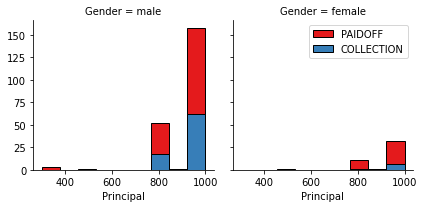

In [216]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

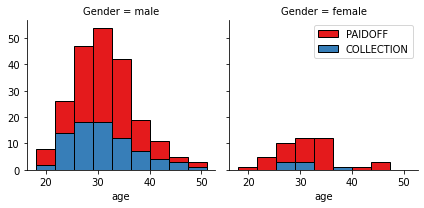

In [217]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Lets look at the day of the week people get the loan


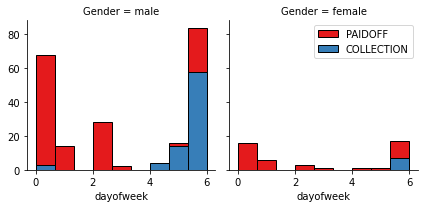

In [218]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 


In [219]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:


In [220]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay their loans while only 73 % of males pay their loan


Lets convert male to 0 and female to 1:


In [221]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [222]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding


In [223]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [224]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection


Lets defind feature sets, X:


In [225]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [226]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [227]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

C:\Users\caesp\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\caesp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

-   K Nearest Neighbor(KNN)
-   Decision Tree
-   Support Vector Machine
-   Logistic Regression

** Notice:** 

-   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
-   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
-   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [228]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [229]:
# Dividing the dataset into test/train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

Training set shape (X_train, y_train): (276, 8) (276,)
Testing set shape (X_test, y_test): (70, 8) (70,)


In [230]:
# Calculating the mean accuracy of KNN for different Ks paremeters
Ks = 10
mean_acc = np.zeros((Ks - 1))
std_acc = np.zeros((Ks - 1))
for i in range(1, Ks):
    # Modeling the Decision Tree: KNN_clf
    KNN_clf = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    yhat = KNN_clf.predict(X_test)
    
    mean_acc[i-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[i-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])
    
    print("For K={}, Accuracy = {:.5%}".format(i, mean_acc[i-1]))

For K=1, Accuracy = 67.14286%
For K=2, Accuracy = 65.71429%
For K=3, Accuracy = 71.42857%
For K=4, Accuracy = 68.57143%
For K=5, Accuracy = 75.71429%
For K=6, Accuracy = 71.42857%
For K=7, Accuracy = 78.57143%
For K=8, Accuracy = 75.71429%
For K=9, Accuracy = 75.71429%


With K=7, we reach the best Accuracy = 78.57143%
KNN Jaccard score = 78.57143%
KNN F1-score = 77.66540%


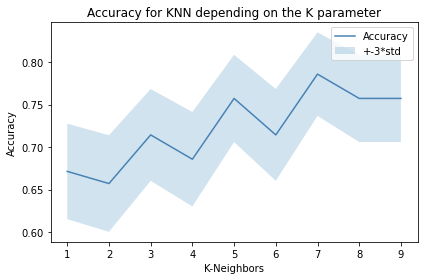

In [231]:
# Printing the score results
print("With K={}, we reach the best Accuracy = {:.5%}".format(mean_acc.argmax()+1, mean_acc.max()))

# Resetting the KNN model
KNN_clf = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train, y_train)
yhat = KNN_clf.predict(X_test)

# Calculating Jaccard, F1-score & LogLoss Accuracy
KNN_jcc = metrics.jaccard_similarity_score(y_test, yhat)
KNN_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("KNN Jaccard score = {:.5%}".format(KNN_jcc))
print("KNN F1-score = {:.5%}".format(KNN_f1))

# Plotting the previous results
plt.plot(range(1, Ks), mean_acc, 'steelblue')
plt.fill_between(range(1, Ks), mean_acc - std_acc, mean_acc + std_acc, alpha=0.2)

plt.title('Accuracy for KNN depending on the K parameter')
plt.xlabel('K-Neighbors')
plt.ylabel('Accuracy')
plt.legend(('Accuracy', '+-3*std'))

plt.tight_layout()
plt.show()

# Decision Tree


In [232]:
from sklearn.tree import DecisionTreeClassifier

In [233]:
# Calculating the mean accuracy of the Decision Tree for different max_depth paremeters
max_depth_n = 11
mean_acc_tree = np.zeros((max_depth_n - 1))
std_acc_tree = np.zeros((max_depth_n - 1))
for n in range(1, max_depth_n):
    # Modeling the Decision Tree: Tree_clf
    Tree_clf = DecisionTreeClassifier(max_depth=n).fit(X_train, y_train)
    yhat = Tree_clf.predict(X_test)
    
    mean_acc_tree[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc_tree[n-1] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])
    
    print("For max_depth={}, Accuracy = {:.5%}".format(n, mean_acc_tree[n-1]))

For max_depth=1, Accuracy = 78.57143%
For max_depth=2, Accuracy = 78.57143%
For max_depth=3, Accuracy = 61.42857%
For max_depth=4, Accuracy = 61.42857%
For max_depth=5, Accuracy = 62.85714%
For max_depth=6, Accuracy = 77.14286%
For max_depth=7, Accuracy = 75.71429%
For max_depth=8, Accuracy = 72.85714%
For max_depth=9, Accuracy = 64.28571%
For max_depth=10, Accuracy = 71.42857%


With max_depth=6, we reach the best Decision Tree's Accuracy = 78.57143%
Decision Tree's Jaccard score = 77.14286%
Decision Tree's F1-score = 70.64793%


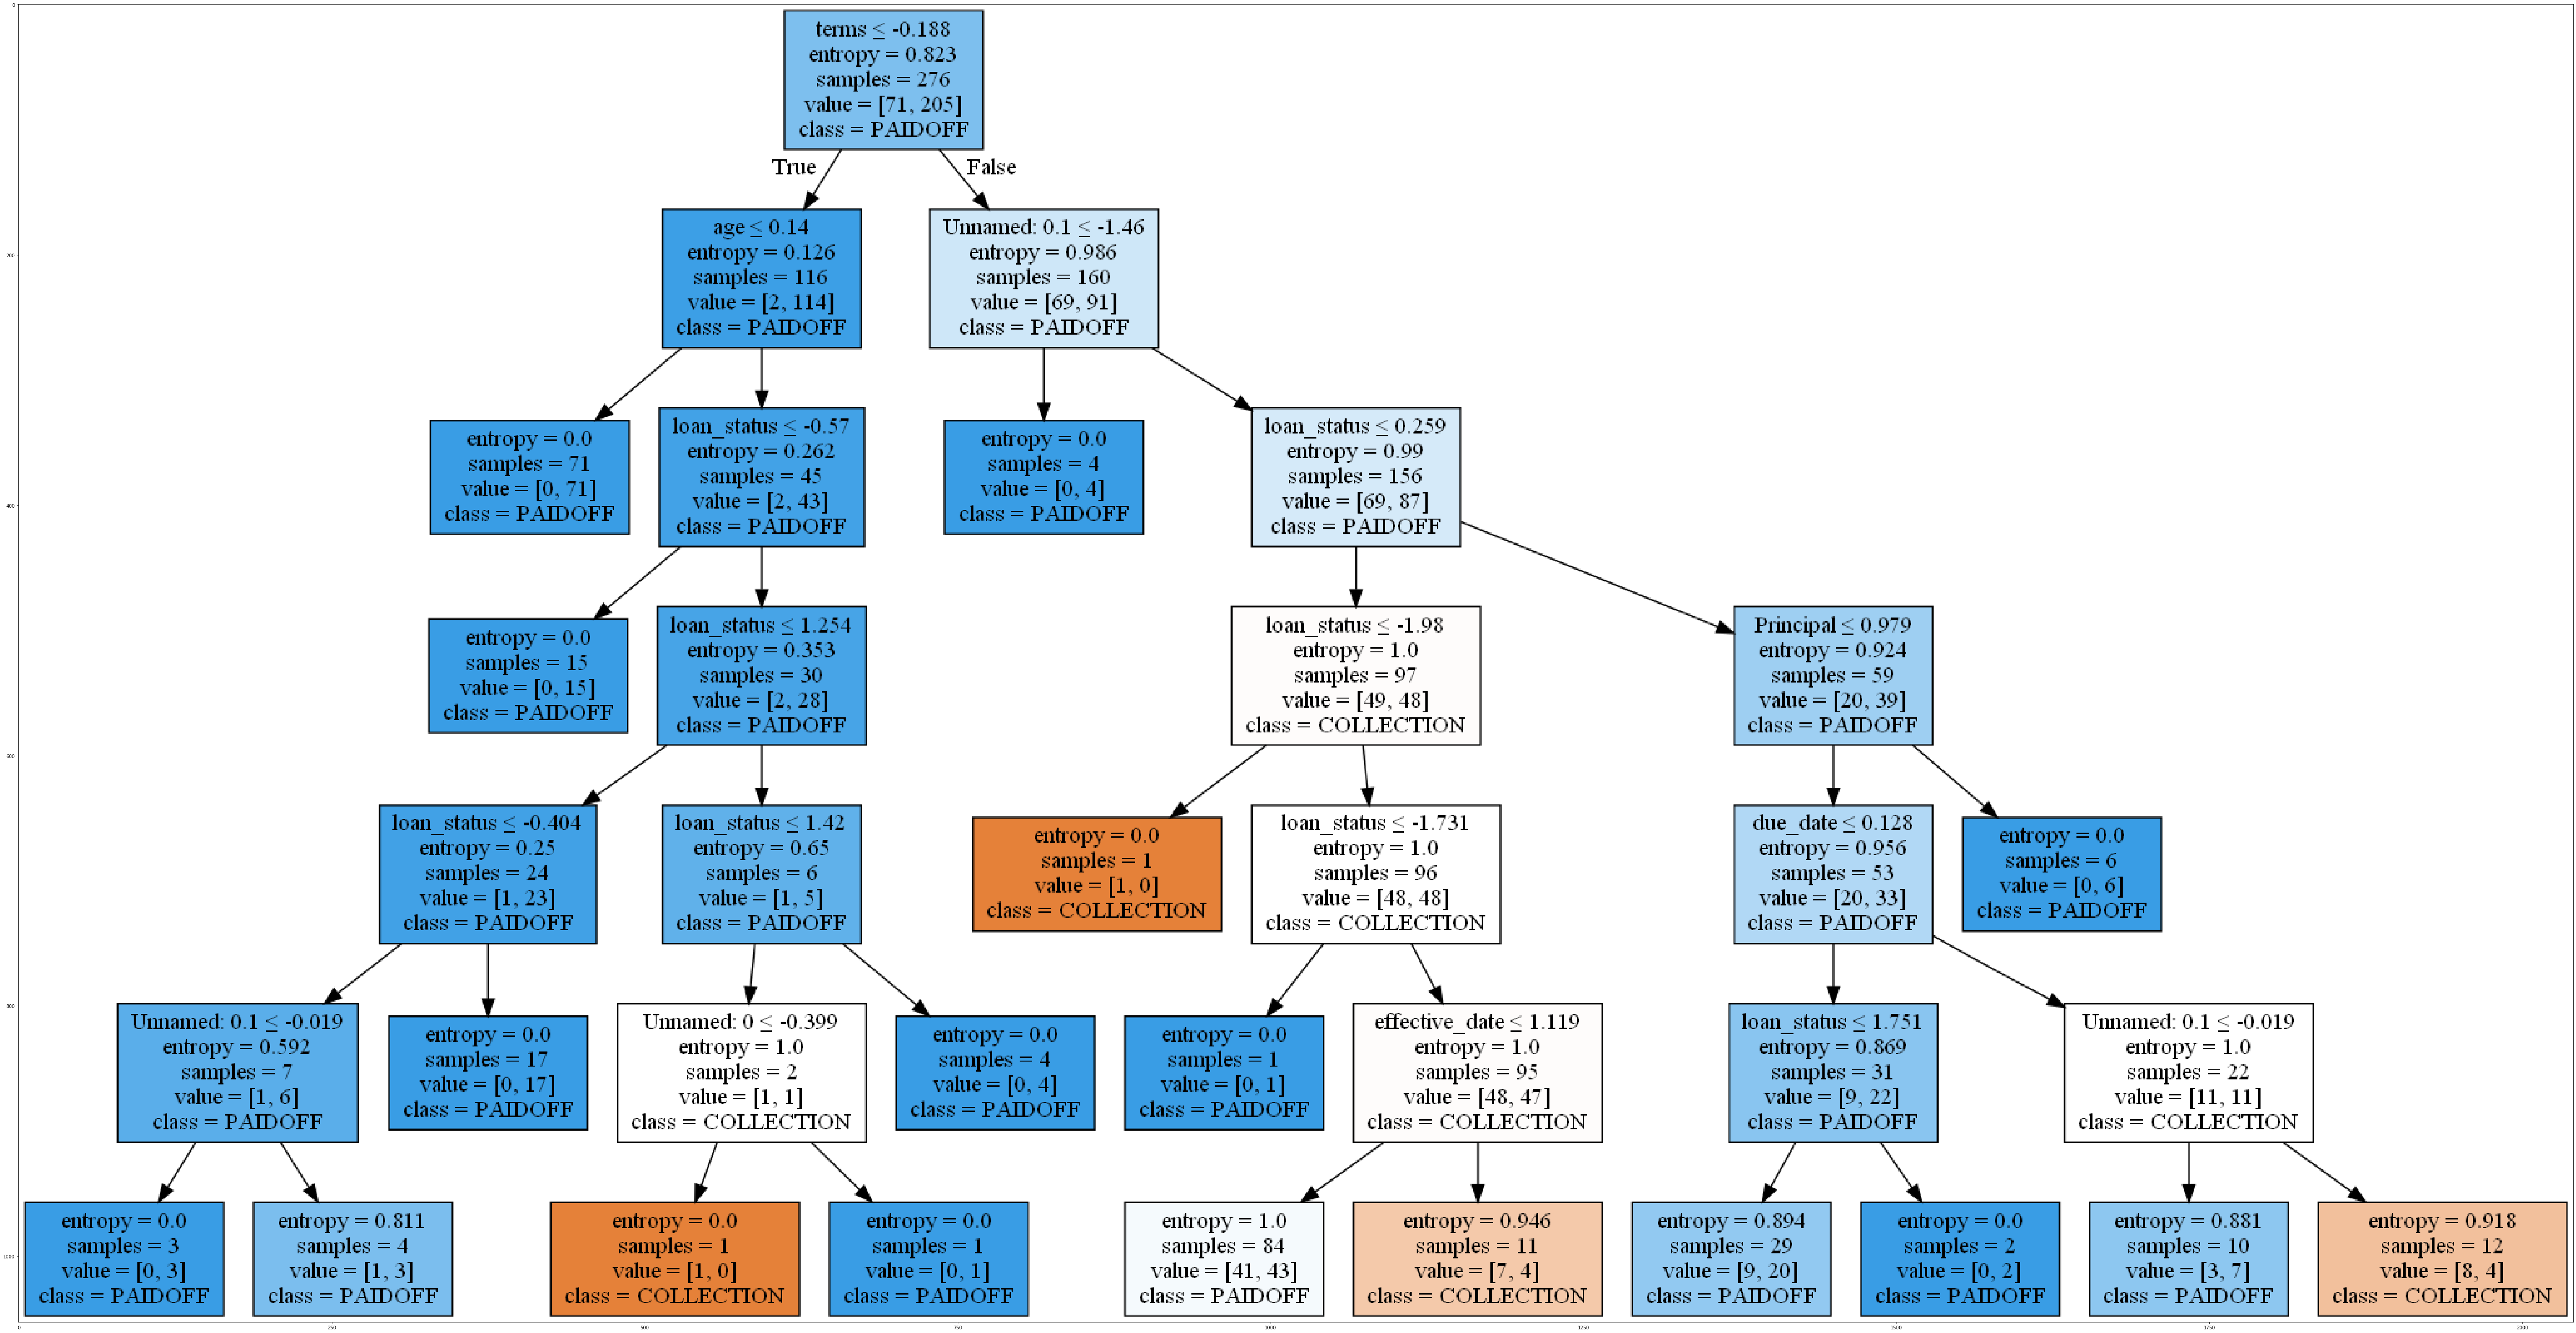

In [234]:
# Printing the score results
print("With max_depth={}, we reach the best Decision Tree's Accuracy = {:.5%}".format(mean_acc_tree.argmax()+6, mean_acc_tree.max()))

# Resetting the model to the one with the best accuracy
Tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=mean_acc_tree.argmax()+6).fit(X_train, y_train)
yhat = Tree_clf.predict(X_test)

# Calculating Jaccard, F1-score & LogLoss Accuracy
DTree_jcc = metrics.jaccard_similarity_score(y_test, yhat)
DTree_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("Decision Tree's Jaccard score = {:.5%}".format(DTree_jcc))
print("Decision Tree's F1-score = {:.5%}".format(DTree_f1))

# Plotting the decision tree
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

dot_data = StringIO()
filename = "loan_status_tree.png"
featureNames = df.columns[0:8]
targetNames = df["loan_status"].unique().tolist()
out=tree.export_graphviz(Tree_clf, feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [235]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [236]:
# Building the SVM Model
svm_clf = SVC(C=100, kernel='poly', gamma='auto').fit(X_train, y_train)
yhat = svm_clf.predict(X_test)

SVM Classification report:
               precision    recall  f1-score   support

  COLLECTION       0.36      0.60      0.45        15
     PAIDOFF       0.87      0.71      0.78        55

   micro avg       0.69      0.69      0.69        70
   macro avg       0.61      0.65      0.62        70
weighted avg       0.76      0.69      0.71        70

SVM Jaccard score = 68.57143%
SVM F1-score = 70.92857%
Confusion matrix, without normalization
[[39 16]
 [ 6  9]]


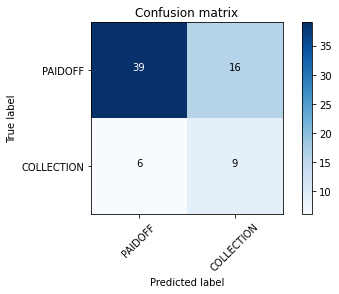

In [237]:
# Printing the results
SVM_jcc = metrics.jaccard_similarity_score(y_test, yhat)
SVM_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("SVM Classification report:\n", metrics.classification_report(y_test, yhat))
print("SVM Jaccard score = {:.5%}".format(SVM_jcc))
print("SVM F1-score = {:.5%}".format(SVM_f1))

# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Calculating the confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF', 'COLLECTION'])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False, title='Confusion matrix')

# Logistic Regression


In [238]:
from sklearn.linear_model import LogisticRegression

In [239]:
# Conforming the model
LR = LogisticRegression(C=1000, solver='liblinear').fit(X_train, y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
print(yhat_prob[0:5])

[[0.52696375 0.47303625]
 [0.39668013 0.60331987]
 [0.01630004 0.98369996]
 [0.02477098 0.97522902]
 [0.01645914 0.98354086]]


LR Classification report:
               precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

LR Jaccard score = 71.42857%
LR F1-score = 68.59606%
LR LogLoss = 56.72273%
Confusion matrix, without normalization
[[48  7]
 [13  2]]


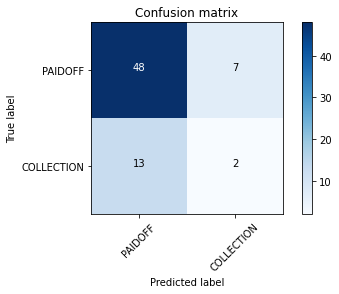

In [240]:
# Evaluating the model
LR_jcc = metrics.jaccard_similarity_score(y_test, yhat)
LR_f1 = metrics.f1_score(y_test, yhat, average='weighted')
LR_logloss = metrics.log_loss(y_test, yhat_prob)
print("LR Classification report:\n", metrics.classification_report(y_test, yhat))
print("LR Jaccard score = {:.5%}".format(LR_jcc))
print("LR F1-score = {:.5%}".format(LR_f1))
print("LR LogLoss = {:.5%}".format(LR_logloss))

# Confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF', 'COLLECTION'])

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'], normalize=False, title='Confusion matrix')

# Model Evaluation using Test set


In [241]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [242]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-10-13 01:45:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: 'loan_test.csv'

     0K ...                                                   100% 4.88M=0.001s

2020-10-13 01:45:58 (4.88 MB/s) - 'loan_test.csv' saved [3642/3642]



### Load Test set for evaluation


In [243]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [244]:
# Conforming the test set: X_test, y_test
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature, pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1, inplace=True)
X_test = Feature
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test) # standardization of the test set
print(X_test[0:5])

y_test = test_df['loan_status'].values
print(y_test[0:5])

print(X_test.shape, X_train.shape, y_test.shape, y_train.shape)

[[ 0.49362588  0.92844966  3.05981865  1.97714211 -1.30384048  2.39791576
  -0.79772404 -0.86135677]
 [-3.56269116 -1.70427745  0.53336288 -0.50578054  0.76696499 -0.41702883
  -0.79772404 -0.86135677]
 [ 0.49362588  0.92844966  1.88080596  1.97714211  0.76696499 -0.41702883
   1.25356634 -0.86135677]
 [ 0.49362588  0.92844966 -0.98251057 -0.50578054  0.76696499 -0.41702883
  -0.79772404  1.16095912]
 [-0.66532184 -0.78854628 -0.47721942 -0.50578054  0.76696499  2.39791576
  -0.79772404 -0.86135677]]
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54, 8) (276, 8) (54,) (276,)


C:\Users\caesp\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\caesp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [245]:
# Rebuilding the models with the best parameters already found on the train/test split
# Train variables: X_train, y_train / Test variables: X_test, y_test
X_train = X.copy()
y_train = y.copy()

In [246]:
# KNN
KNN_clf = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X_train, y_train)
yhat = KNN_clf.predict(X_test)

KNN_jcc = metrics.jaccard_similarity_score(y_test, yhat)
KNN_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("KNN Jaccard score = {:.5%}".format(KNN_jcc))
print("KNN F1-score = {:.5%}".format(KNN_f1))

KNN Jaccard score = 72.22222%
KNN F1-score = 70.01989%


In [247]:
# Decision Tree
Tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=mean_acc_tree.argmax()+6).fit(X_train, y_train)
yhat = Tree_clf.predict(X_test)

DTree_jcc = metrics.jaccard_similarity_score(y_test, yhat)
DTree_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("Decision Tree Jaccard score = {:.5%}".format(DTree_jcc))
print("Decision Tree F1-score = {:.5%}".format(DTree_f1))

Decision Tree Jaccard score = 74.07407%
Decision Tree F1-score = 70.06734%


In [248]:
# SVM
svm_clf = SVC(C=100, kernel='poly', gamma='auto').fit(X_train, y_train)
yhat = svm_clf.predict(X_test)

SVM_jcc = metrics.jaccard_similarity_score(y_test, yhat)
SVM_f1 = metrics.f1_score(y_test, yhat, average='weighted')
print("SVM Jaccard score = {:.5%}".format(SVM_jcc))
print("SVM F1-score = {:.5%}".format(SVM_f1))

SVM Jaccard score = 72.22222%
SVM F1-score = 71.87929%


In [249]:
# LogReg
LR = LogisticRegression(C=1000, solver='lbfgs').fit(X_train, y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

LR_jcc = metrics.jaccard_similarity_score(y_test, yhat)
LR_f1 = metrics.f1_score(y_test, yhat, average='weighted')
LR_logloss = metrics.log_loss(y_test, yhat_prob)
print("LR Jaccard score = {:.5%}".format(LR_jcc))
print("LR F1-score = {:.5%}".format(LR_f1))
print("LR LogLoss = {:.5%}".format(LR_logloss))

LR Jaccard score = 75.92593%
LR F1-score = 67.17642%
LR LogLoss = 48.72164%


In [250]:
# Consolidating the Accuracy Report
df_acc = pd.DataFrame({'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'LogisticRegression'],
                       'Jaccard': [KNN_jcc, DTree_jcc, SVM_jcc, LR_jcc],
                       'F1-score': [KNN_f1, DTree_f1, SVM_f1, LR_f1],
                       'LogLoss': [np.nan, np.nan, np.nan, LR_logloss]})
df_acc.set_index('Algorithm', inplace=True)
df_acc['Avg'] = (df_acc.Jaccard + df_acc['F1-score']) / 2

print("As we can see in the table below, the best model for out test data (loan_test.csv) is:\n\
{}\n\
Jaccard score: {:.5%}\n\
F1-score: {:.5%}\n\
LogLoss score: {:.5%}".format(df_acc.Avg.idxmax(),\
                         df_acc.loc[df_acc.Avg.idxmax(), 'Jaccard'],\
                         df_acc.loc[df_acc.Avg.idxmax(), 'F1-score'],\
                         df_acc.loc[df_acc.Avg.idxmax(), 'LogLoss']))

df_acc.drop('Avg', axis=1, inplace=True)
df_acc = df_acc.style.format({'Jaccard': '{:.2%}'.format, 'F1-score': '{:.2%}'.format, 'LogLoss': '{:.2%}'.format},\
                             na_rep="NaN")
df_acc

As we can see in the table below, the best model for out test data (loan_test.csv) is:
Decision Tree
Jaccard score: 74.07407%
F1-score: 70.06734%
LogLoss score: nan%


,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,72.22%,70.02%,NaN
Decision Tree,74.07%,70.07%,NaN
SVM,72.22%,71.88%,NaN
LogisticRegression,75.93%,67.18%,48.72%


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description  |
| ----------------- | ------- | ------------- | ------------------- |
| 2020-08-27        | 1.0     | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
